# Prototypical Implementation of a flow through a porous medium

In [1]:
import lettuce as lt
import torch

## Define Flow and Boundary Condition

In [2]:
class PeriodicPressureBC:
    """According to Ehsan Evati: 'High performance simulation of fluid flow in porous media...' 
    """
    def __init__(self, lattice, delta_rho):
        self.lattice = lattice
        self.delta_rho = delta_rho
        
    def __call__(self, f):
        f[[1,5,8],0,:] = f[[1,5,8],0,:] + self.lattice.w[[1,5,8],None] * self.delta_rho
        f[[3,6,7],-1,:] = f[[3,6,7],-1,:] - self.lattice.w[[3,6,7],None] * self.delta_rho
        return f

In [3]:
class PorousMedium2D(lt.Obstacle2D):
    def __init__(
            self,
            pressure_difference, 
            resolution_x,
            resolution_y,
            reynolds_number,
            mach_number,
            lattice,
            char_length_lu
    ):
        super().__init__(
            resolution_x,
            resolution_y,
            reynolds_number,
            mach_number,
            lattice,
            char_length_lu
        )
        self.pressure_difference = pressure_difference
    
    @property
    def delta_rho(self):
        rho_in = self.units.convert_pressure_pu_to_density_lu(self.pressure_difference/2)
        rho_out = self.units.convert_pressure_pu_to_density_lu(-self.pressure_difference/2)
        return rho_in - rho_out
    
    @property
    def boundaries(self):
        return [
            # left/right
            PeriodicPressureBC(self.units.lattice, self.delta_rho),
            # bounce back periodic medium
            lt.BounceBackBoundary(self.mask, self.units.lattice)
            # periodic in y direction
        ]

## Make Flow

The Re and Ma are pretty aribtrary here. Should probably be computed from the pressure difference.

In [4]:
import numpy as np

nx = 150
ny = 500
n_buffer = 50
pressure_difference = 0.5

lattice = lt.Lattice(lt.D2Q9, "cuda:0", torch.float64)
flow = PorousMedium2D(
    pressure_difference, ny, nx, reynolds_number=500., mach_number=0.05, 
    lattice=lattice, char_length_lu=ny
)

# make porous medium by inserting random circles
np.random.seed(234269)
n_circles = 30
for i in range(n_circles):
    x, y = flow.grid
    x0 = np.random.rand()
    y0 = np.random.rand()*y.max()
    r = 0.02 + 0.02 * np.random.rand()
    circle = ((x-x0)**2 + (y-y0)**2 < r**2)
    flow.mask[circle] = 1

# make a buffer region that should have constant pressure
flow.mask[:n_buffer, :] = 0
flow.mask[-n_buffer:, :] = 0

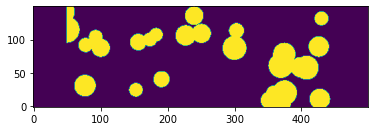

In [5]:
from matplotlib import pyplot as plt
plt.imshow(flow.mask.transpose(), origin="lower")

## Run Simulation

In [6]:
collision = lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.Simulation(lattice=lattice, flow=flow, streaming=streaming, collision=collision)

In [7]:
from tqdm.auto import tqdm

print(simulation.f.sum())
for _ in tqdm(range(1000)):   
    simulation.step(100)
print(simulation.f.sum())  # check mass conservation

tensor(75000., device='cuda:0', dtype=torch.float64)


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(75000.0000, device='cuda:0', dtype=torch.float64)


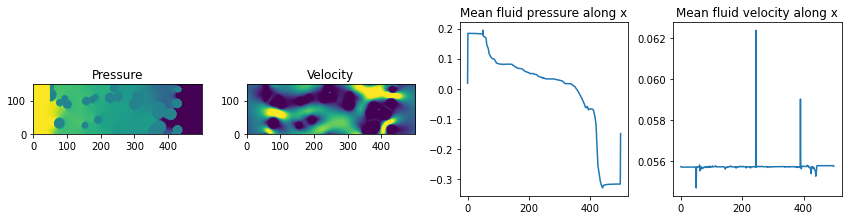

In [8]:
from matplotlib import pyplot as plt
u = lattice.u(simulation.f)
rho = lattice.rho(simulation.f)
u = flow.units.convert_velocity_to_pu(u).cpu().detach().numpy()
p = flow.units.convert_density_lu_to_pressure_pu(rho).cpu().detach().numpy()
unorm = np.linalg.norm(u, axis=0)

# Plot without outliers due to bounce-back contacts
fig, axes = plt.subplots(1,4, figsize=(12,3))
fig.tight_layout()
axes[0].set_title("Pressure")
axes[0].imshow(p[0].transpose(), origin="lower", vmin=p[0,ny-1,0], vmax=p[0].mean(axis=-1).max())
axes[1].set_title("Velocity")
axes[1].imshow(unorm.transpose(), origin="lower",
               vmin=np.percentile(unorm.flatten(),1),
               vmax=np.percentile(unorm.flatten(),95))
axes[2].set_title("Mean fluid pressure along x")
axes[2].plot(p[0].sum(axis=-1)/(np.logical_not(flow.mask).sum(axis=-1)))
axes[3].set_title("Mean fluid velocity along x")
axes[3].plot(u[0].mean(axis=-1))

- Note: something is wrong with bounce back when there is only one fluid node between two BB nodes. Leads to spikes in velocity.